# Predicting Box Office Revenue

In [640]:
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.stats import zscore
import statsmodels.formula.api as smf
import statsmodels.api as sm

### Data cleanup

Join to two dataset files by movie id, and drop duplicate columns.

In [641]:
movies_data = pd.read_csv('../tmdb_5000_movies.csv')
credits_data = pd.read_csv('../tmdb_5000_credits.csv')

# Perform an inner join on the movies and credits data so it's all in one dataframe
all_movies_data = pd.merge(movies_data, credits_data, left_on='id', right_on='movie_id', how='inner', suffixes=('_movies', '_credits'))

# Drop duplicate id and title fields
all_movies_data = all_movies_data.drop(columns=['movie_id', 'title_credits'])
# Rename original title field
all_movies_data = all_movies_data.rename(columns={'title_movies': 'title'})

print('Movies remaining in dataset after merge: {}'.format(len(all_movies_data)))

Movies remaining in dataset after merge: 4803


Drop rows with no budget or revenue data, since that's what we want to analyze. 

In [642]:
# Remove data with no revenue or budget info
all_movies_data = all_movies_data[all_movies_data['budget'] > 0]
all_movies_data = all_movies_data[all_movies_data['revenue'] > 0]

print('Movies remaining in dataset after dropping rows without budget or revenue data: {}'.format(len(all_movies_data)))

Movies remaining in dataset after dropping rows without budget or revenue data: 3229


Remove upper bound revenue outliers, otherwise every result looks just suggests "Make an action movie with James Cameron".

In [643]:
all_movies_data['revenue_zscore'] = zscore(all_movies_data['revenue'])
all_movies_data = all_movies_data[all_movies_data['revenue_zscore'] <= 3]
print('Movies remaining in dataset after removing upper revenue outliers: {}'.format(len(all_movies_data)))

Movies remaining in dataset after removing upper revenue outliers: 3146


Log transform revenue and budget data

In [644]:
all_movies_data['sqrt_budget'] = all_movies_data['budget'].apply(lambda x: np.sqrt(x))
all_movies_data['sqrt_revenue'] = all_movies_data['revenue'].apply(lambda x: np.sqrt(x))

Convert the genres field from a string to a list of dictionaries. Drop rows that cannot be formatted, or contain an empty list of genres.

In [645]:
def format_json(string_list):
    try:
        return json.loads(string_list)
    except (ValueError, SyntaxError, TypeError):
        return np.nan

# Avoiding in-place modification here so the cells run smoothly
all_movies_data['formatted_genres'] = all_movies_data['genres'].apply(format_json)
# Drop rows that cannot be formatted
all_movies_data = all_movies_data[all_movies_data['formatted_genres'] != np.nan]
# Drop rows that contain an empty genre list
all_movies_data = all_movies_data[all_movies_data['formatted_genres'].apply(lambda x: len(x) > 0)]

print('Formatted genre field example: {}'.format(all_movies_data.iloc[0]['formatted_genres']))
print('Movies remaining in dataset after formatting genres: {}'.format(len(all_movies_data)))

Formatted genre field example: [{'id': 28, 'name': 'Action'}, {'id': 12, 'name': 'Adventure'}, {'id': 878, 'name': 'Science Fiction'}]
Movies remaining in dataset after formatting genres: 3145


Create a `primary_genre` and `primary_genre_id` column for easier access later.

In [646]:
# Create primary_genre column using the first genre in the genre list
all_movies_data['primary_genre'] = all_movies_data['formatted_genres'].apply(lambda x: x[0]['name'])
all_movies_data['primary_genre_id'] = all_movies_data['formatted_genres'].apply(lambda x: x[0]['id'])
print('Primary genre field example: {}'.format(all_movies_data.iloc[0]['primary_genre']))
print('Primary genre id field example: {}'.format(all_movies_data.iloc[0]['primary_genre_id']))

Primary genre field example: Action
Primary genre id field example: 28


Format production_companies field

In [647]:

all_movies_data['formatted_prod_companies'] = all_movies_data['production_companies'].apply(format_json)
all_movies_data = all_movies_data[all_movies_data['formatted_prod_companies'] != np.nan]
all_movies_data = all_movies_data[all_movies_data['formatted_prod_companies'].apply(lambda x: len(x) > 0)]

print('Formatted production company field example: {}'.format(all_movies_data.iloc[0]['formatted_prod_companies']))
print('Movies remaining in dataset after formatting genres: {}'.format(len(all_movies_data)))

Formatted production company field example: [{'name': 'Walt Disney Pictures', 'id': 2}]
Movies remaining in dataset after formatting genres: 3105


Format keywords field

In [648]:
all_movies_data['formatted_keywords'] = all_movies_data['keywords'].apply(format_json)
all_movies_data = all_movies_data[all_movies_data['formatted_keywords'] != np.nan]
all_movies_data = all_movies_data[all_movies_data['formatted_keywords'].apply(lambda x: len(x) > 0)]

print('Formatted production company field example: {}'.format(all_movies_data.iloc[0]['formatted_keywords']))
print('Movies remaining in dataset after formatting genres: {}'.format(len(all_movies_data)))

Formatted production company field example: [{'id': 818, 'name': 'based on novel'}, {'id': 839, 'name': 'mars'}, {'id': 1456, 'name': 'medallion'}, {'id': 3801, 'name': 'space travel'}, {'id': 7376, 'name': 'princess'}, {'id': 9951, 'name': 'alien'}, {'id': 10028, 'name': 'steampunk'}, {'id': 10539, 'name': 'martian'}, {'id': 10685, 'name': 'escape'}, {'id': 161511, 'name': 'edgar rice burroughs'}, {'id': 163252, 'name': 'alien race'}, {'id': 179102, 'name': 'superhuman strength'}, {'id': 190320, 'name': 'mars civilization'}, {'id': 195446, 'name': 'sword and planet'}, {'id': 207928, 'name': '19th century'}, {'id': 209714, 'name': '3d'}]
Movies remaining in dataset after formatting genres: 3018


Create `profit` and `profit_ratio` columns.

In [649]:
all_movies_data['profit_ratio'] = all_movies_data['revenue'] / all_movies_data['budget']
all_movies_data['profit'] = all_movies_data['revenue'] - all_movies_data['budget']
print('profit_ratio field example: {}'.format(all_movies_data.iloc[0]['profit_ratio']))
print('profit field example: {}'.format(all_movies_data.iloc[0]['profit']))

profit_ratio field example: 1.0928426923076924
profit field example: 24139100


Create release year and month columns for easier access

In [650]:
all_movies_data['release_year'] = pd.to_datetime(all_movies_data['release_date']).dt.year
all_movies_data['release_month'] = pd.to_datetime(all_movies_data['release_date']).dt.month
print('release_year field example: {}'.format(all_movies_data.iloc[0]['release_year']))
print('release_month field example: {}'.format(all_movies_data.iloc[0]['release_month']))

release_year field example: 2012
release_month field example: 3


### Descriptive Statistics

#### Revenue - general descriptive statistics

In [651]:
all_movies_revenue = all_movies_data['revenue']
mean_all_movies_revenue = np.mean(all_movies_revenue)
median_all_movies_revenue = np.median(all_movies_revenue)
std_all_movies_revenue = np.std(all_movies_revenue)

all_movies_data[['revenue']].describe().style.format("{:,.2f}")

,revenue
count,"3,018.00"
mean,"102,751,598.34"
std,"124,505,005.29"
min,5.00
25%,"17,720,101.25"
50%,"55,645,607.50"
75%,"139,951,087.00"
max,"677,945,399.00"


#### Budget - general descriptive statistics

In [652]:
all_movies_budget = all_movies_data['budget']
mean_all_movies_revenue = np.mean(all_movies_budget)
median_all_movies_revenue = np.median(all_movies_budget)
std_all_movies_revenue = np.std(all_movies_budget)

all_movies_data[['budget']].describe().style.format("{:,.2f}")

,budget
count,"3,018.00"
mean,"38,295,381.21"
std,"39,193,149.84"
min,1.00
25%,"11,000,000.00"
50%,"25,000,000.00"
75%,"52,000,000.00"
max,"270,000,000.00"


#### Revenue:Budget Profit Ratio - general descriptive statistics

In [653]:
all_movies_data['profit_ratio'] = all_movies_data['revenue'] / all_movies_data['budget']

all_movies_profit_ratio = all_movies_data['profit_ratio']
mean_all_movies_revenue = np.mean(all_movies_profit_ratio)
median_all_movies_revenue = np.median(all_movies_profit_ratio)
std_all_movies_revenue = np.std(all_movies_profit_ratio)

all_movies_data[['profit_ratio']].describe().style.format("{:,.2f}")

,profit_ratio
count,"3,018.00"
mean,"3,159.25"
std,"155,785.63"
min,0.00
25%,1.04
50%,2.28
75%,4.33
max,"8,500,000.00"


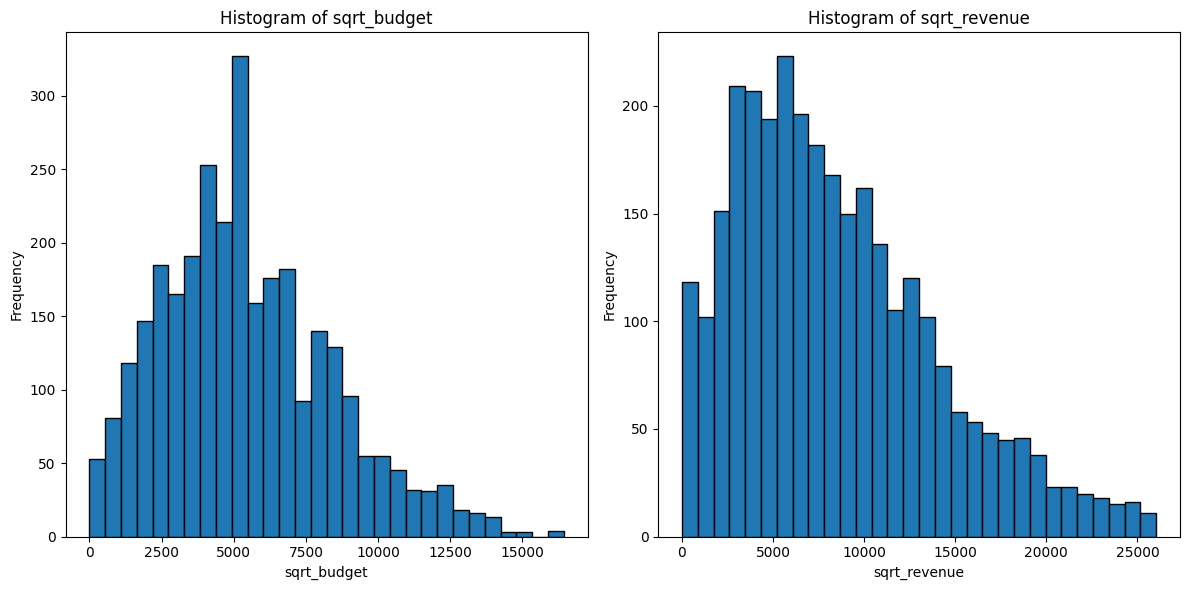

In [654]:
# Plot histograms of log_budget and log_revenue
plt.figure(figsize=(12, 6))

# Histogram for sqrt_budget
plt.subplot(1, 2, 1)
plt.hist(all_movies_data['sqrt_budget'], bins=30, edgecolor='black')
plt.title('Histogram of sqrt_budget')
plt.xlabel('sqrt_budget')
plt.ylabel('Frequency')

# Histogram for sqrt_revenue
plt.subplot(1, 2, 2)
plt.hist(all_movies_data['sqrt_revenue'], bins=30, edgecolor='black')
plt.title('Histogram of sqrt_revenue')
plt.xlabel('sqrt_revenue')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Scatter plot of Budget vs Revenue by Primary genre

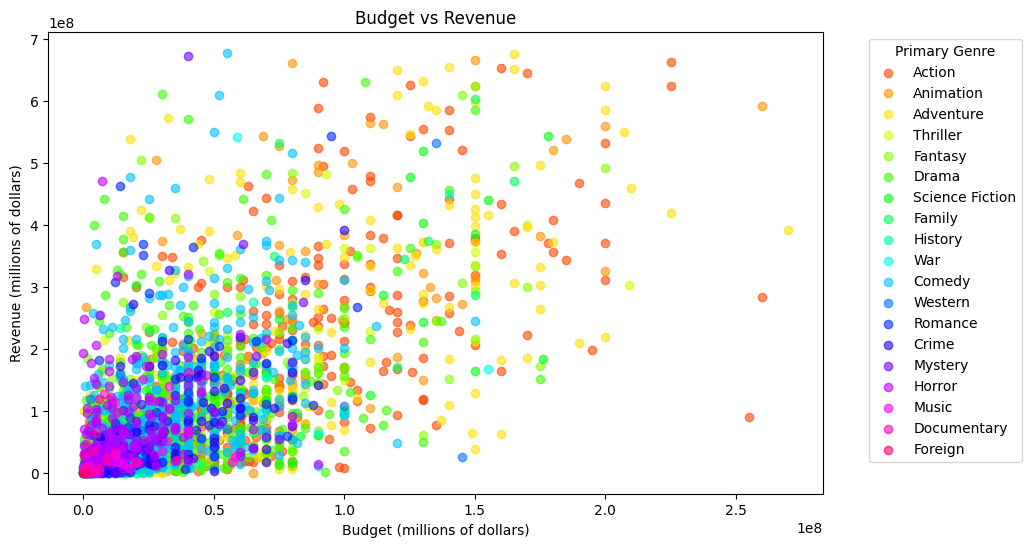

In [655]:
# Create a color palette
unique_genres = all_movies_data['primary_genre'].unique()
genre_palette = sns.color_palette('hsv', len(unique_genres))
genre_color_map = dict(zip(unique_genres, genre_palette))

# Create a scatter plot of budget vs revenue by genre
plt.figure(figsize=(10, 6))
for genre in unique_genres:
    subset = all_movies_data[all_movies_data['primary_genre'] == genre]
    plt.scatter(subset['budget'], subset['revenue'], label=genre, color=genre_color_map[genre], alpha=0.6)
plt.title('Budget vs Revenue')
plt.xlabel('Budget (millions of dollars)')
plt.ylabel('Revenue (millions of dollars)')
plt.legend(title='Primary Genre', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

Side-by-side box plots of profit and profit_ratio by genre

/var/folders/q4/_1_vts6n2vg5rvqrn52fvfd00000gn/T/ipykernel_81826/1060858280.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='primary_genre', y='profit', data=all_movies_data, palette=genre_color_map)


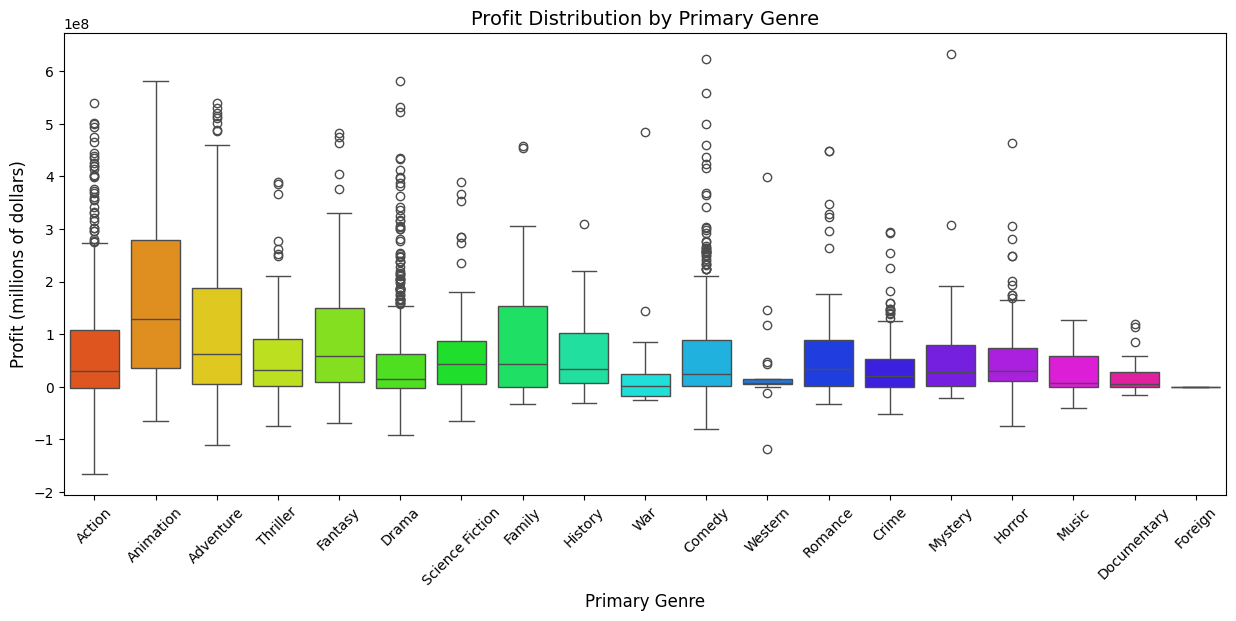

In [656]:
plt.figure(figsize=(15, 6))
sns.boxplot(x='primary_genre', y='profit', data=all_movies_data, palette=genre_color_map)

plt.title('Profit Distribution by Primary Genre', fontsize=14)
plt.xlabel('Primary Genre', fontsize=12)
plt.ylabel('Profit (millions of dollars)', fontsize=12)
plt.xticks(rotation=45)

plt.show()

### Linear regression

In [657]:
formula = 'profit ~ sqrt_budget + release_month'

model = smf.glm(formula=formula, data=all_movies_data, family=sm.families.Gaussian()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 profit   No. Observations:                 3018
Model:                            GLM   Df Residuals:                     3015
Model Family:                Gaussian   Df Model:                            2
Link Function:               Identity   Scale:                      8.9293e+15
Method:                          IRLS   Log-Likelihood:                -59704.
Date:                Mon, 07 Oct 2024   Deviance:                   2.6922e+19
Time:                        15:12:12   Pearson chi2:                 2.69e+19
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1734
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2.146e+07   5.02e+06     -4.278      0.000   -3.13e+07   -1.16e+07
sqrt_budget    1.381e+04    582.498     23.700      0.000    1.27e+04    1.49e+04
release_month  1.547e+06   5.09e+05      3.040      0.002     5.5e+05    2.54e+06
=================================================================================
"""